In [1]:
import app.curve as curve
import app.calibration as c
import app.warp as w
import app.edges as e
import app.lane_finder as lf

import cv2
import matplotlib.pyplot as plt
import importlib
import numpy as np

from moviepy.editor import VideoFileClip
import matplotlib.image as mpimg
from IPython.display import HTML
%matplotlib inline

## Advanced Lane Finding Project

Final results:

[Project Video 1](https://www.youtube.com/watch?v=ETCjhhBV19Y)

[Project Video 2 Added bird eye view](https://www.youtube.com/watch?v=1HO_AeByt6k)

[Challenge Video](https://www.youtube.com/watch?v=1HO_AeByt6k)


### The Goal of this Project

The goal of this project is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car.

### Camera Calibration

The code of camera calibration is defined in `app/calibration.py`. First time the code will load all provided chessboard images. Using those images it will detect `object points` which will be the (x, y, z) coordinates of the chessboard corners in the
world also `image points` pixel position of each of the corners in the image plane with each successful chessboard detection. of the chessboard.
Then using all output `object points` and `image points` it will compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function. Here is an example of the distortion correction

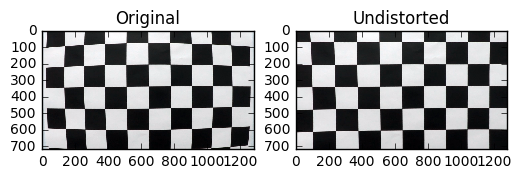

In [2]:
img = cv2.imread('camera_cal/calibration1.jpg')
cam_calib = c.Camera_calibrator()
cam_calib.initialize()

calibrator = c.Camera_calibrator()
calibrator.initialize()
undist = calibrator.undistort(img)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original')

plt.subplot(1,2,2)
plt.title('Undistorted')
plt.imshow( undist )

Here is an example on the final result on one of the provided test image.

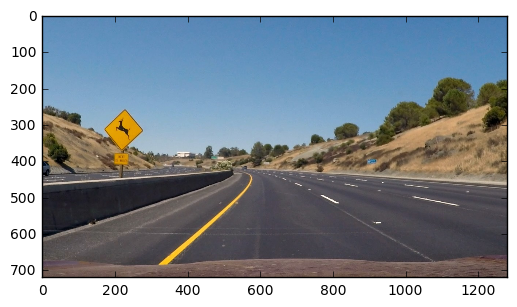

In [3]:
img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
calibrator.undistort(img)
plt.imshow(img)

## Detecting lanes


First we need to create binary image which should approximatly show lane lines. To achieve this results we will use the following transformations:

* Equalize colour histogram
* Convert image to LUV colour space. On L channel apply threshold with **min = 250** and **max = 255**. This is good for detecting white line
* Convert image to LAB colour space. On B channel apply threshold with **min = 140** and **max = 255**. This is good for detecting yellow line
* Convert image to gray scale and apply threshold with **min = 245** and **max = 255**
* All masks are combined into one binary image. And this one works on both images, however poorly identifies yellow lines


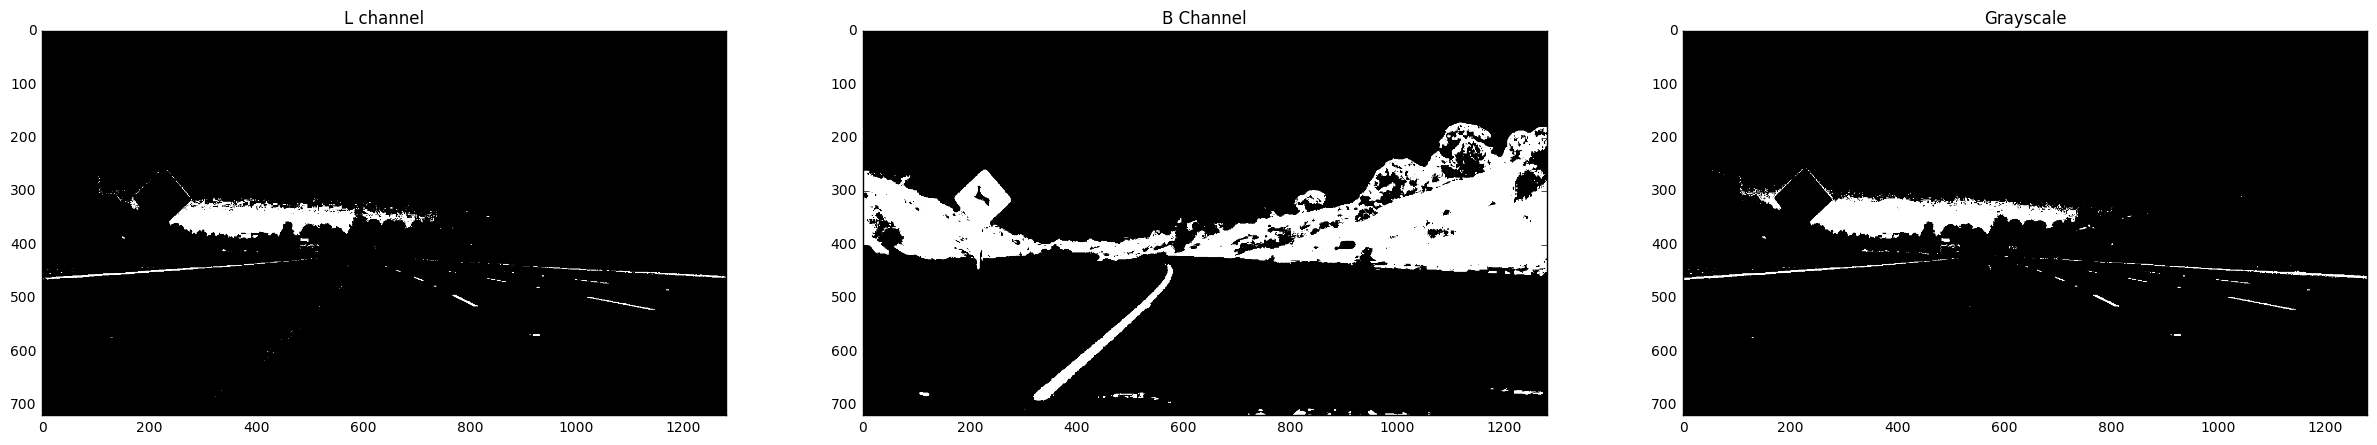

In [4]:
# Function which equalizes histogram on colour image
def equalize_color_hist(img):
    ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    ycrcb[:,:,0] = cv2.equalizeHist(ycrcb[:,:,0])
    result = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)
    return result

equalized = equalize_color_hist(img)
edges = e.Edges(equalized)

luv_mask = edges.gradient_color_channel(250,255,0,space=cv2.COLOR_RGB2LUV) # white
lab_mask = edges.gradient_color_channel(140,255,2,space=cv2.COLOR_RGB2LAB) # yellow
gray_mask = edges.gradient_color_inrange(245, 255, combine=True, space=cv2.COLOR_RGB2GRAY)

plt.subplots(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.title('L channel')
plt.imshow(luv_mask, cmap='gray')

plt.subplot(1,3, 2)
plt.title('B Channel')
plt.imshow(lab_mask, cmap='gray')

plt.subplot(1, 3, 3)
plt.title('Grayscale')
plt.imshow(gray_mask, cmap='gray')

All masks combined

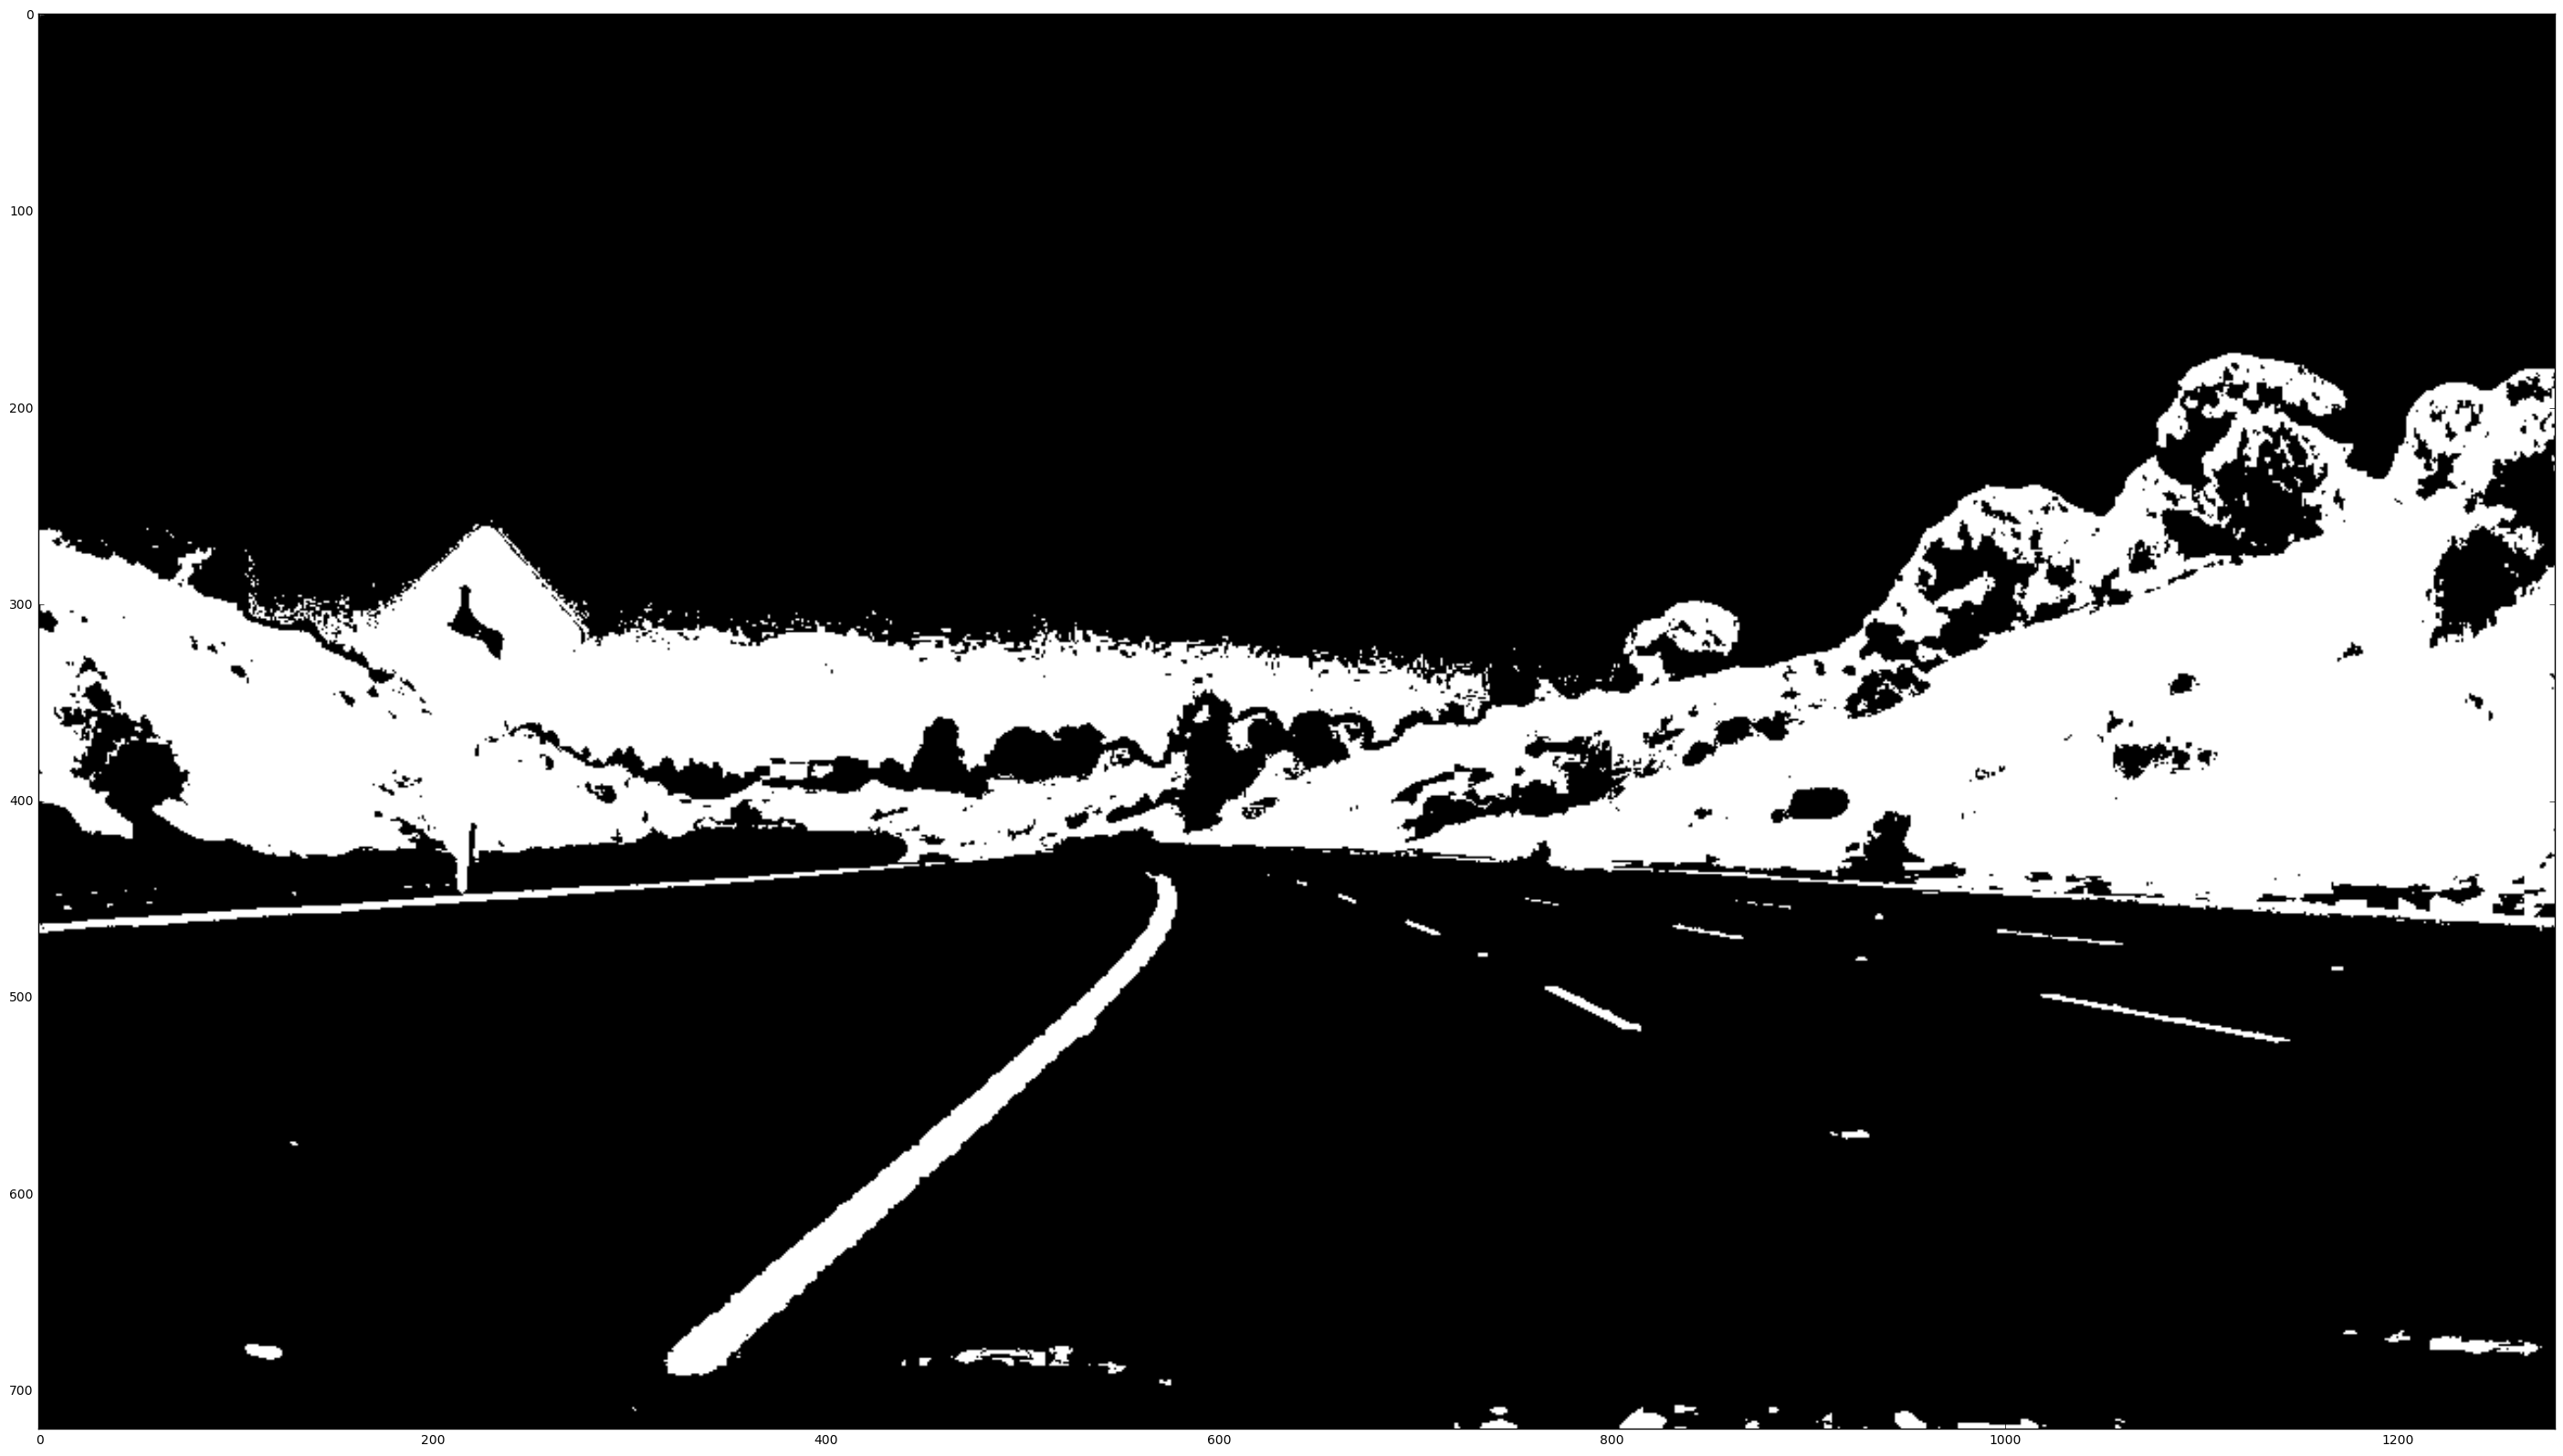

In [5]:
plt.subplots(figsize=(60, 20))
plt.imshow(edges.combined, cmap='gray')

## Bird eye view

The next step is to apply perspective transformation to make the road look like from bird view. The functions which warps image and unwarps are defined in file `app/warp.py`. Function `warp` takes image calculates perspective transformation matrix and and warps the image. Function `unwarp` does the same just use different source points and destination points

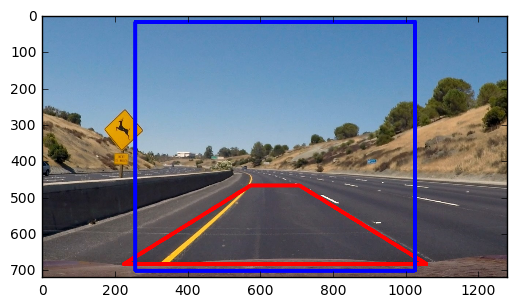

In [6]:
image = img.copy()
w_src = w.get_warp_src(image)
point1 = w_src[0]
point2 = w_src[1]
cv2.line(image, (point1[0], point1[1]), (point2[0], point2[1]), (255,0,0), 10)
point2 = w_src[2]
cv2.line(image, (point1[0], point1[1]), (point2[0], point2[1]), (255,0,0), 10)
point1 = w_src[1]
point2 = w_src[3]
cv2.line(image, (point1[0], point1[1]), (point2[0], point2[1]), (255,0,0), 10)
point1 = w_src[2]
point2 = w_src[3]
cv2.line(image, (point1[0], point1[1]), (point2[0], point2[1]), (255,0,0), 10)

w_src = w.get_warp_dst(image)
point1 = w_src[0]
point2 = w_src[1]
cv2.line(image, (point1[0], point1[1]), (point2[0], point2[1]), (0,0,255), 10)
point2 = w_src[2]
cv2.line(image, (point1[0], point1[1]), (point2[0], point2[1]), (0,0,255), 10)
point1 = w_src[1]
point2 = w_src[3]
cv2.line(image, (point1[0], point1[1]), (point2[0], point2[1]), (0,0,255), 10)
point1 = w_src[2]
point2 = w_src[3]
cv2.line(image, (point1[0], point1[1]), (point2[0], point2[1]), (0,0,255), 10)


plt.imshow(image)

Here is an example how warped image will look

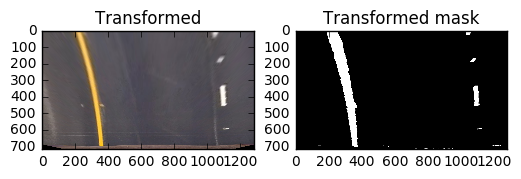

In [7]:
warped = w.warp(img)
w_mask = w.warp(edges.combined)
plt.subplot(1,2,1)
plt.imshow(warped)
plt.title('Transformed')

plt.subplot(1,2,2)
plt.title('Transformed mask')
plt.imshow( w_mask, cmap='gray' )

## Detecting lane

The detection process works in the following way:

* In the binary mask creates a histogram
* Finds 2 peaks in the histogram. On each side left and right. The image is split at the center. Each peak is a starting point along `x` axis. 

Histogram peaks I use that as a starting point for where to search for the lines. From that point, I can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame. Finally using the pixels we found in the binary image we fit the second degree curve and we have final line.

Here is an example of fitted curve

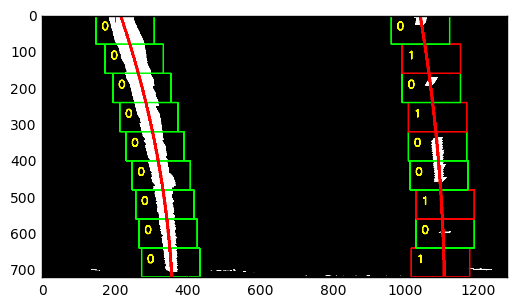

In [14]:
# This function constructs histogram and finds maximum points in the histogram
def get_base_points(img):
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base, rightx_base, histogram

img_y, img_x, _ = img.shape
midpoint = int(img_x/2)
leftx_base, rightx_base, _ = get_base_points(w_mask)
# Curve represents single line. One for left and another for right
l_curve = curve.Curve(leftx_base, (0, midpoint), margin=80)
r_curve = curve.Curve(rightx_base, (midpoint, img_x), margin=80)
l_valid = l_curve.curve_fit(w_mask)
r_valid = r_curve.curve_fit(w_mask)

# Draw the curve and sliding windows on the binary image
s_img = w_mask*255
s_img = cv2.cvtColor(s_img, cv2.COLOR_GRAY2RGB)
# Sliding windows
l_curve.curve_windows.draw_rect(s_img)
r_curve.curve_windows.draw_rect(s_img)
# Curves
l_curve.draw_curve(s_img, thick=4)
r_curve.draw_curve(s_img, thick=4)
plt.imshow(s_img)

Finally we need to unwarp back image and place it on the original image. The function unwarp is defined in `app/warp.py` file.

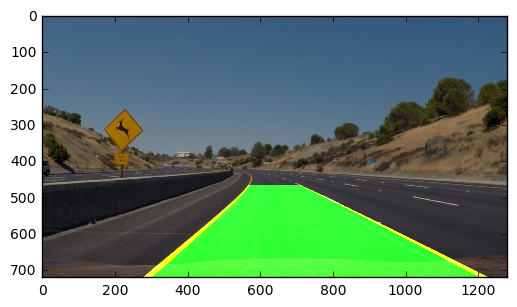

In [19]:
marked = lf.plot_lanes(img, l_curve.fit, r_curve.fit, warped.shape, fill=True)
unwarped = w.unwarp(marked)
final = cv2.addWeighted(img,0.7,unwarped,0.99,0)
plt.imshow(final)

## Stabilisation

Not all road parts are nicely fitted. Some of the areas has different colour and cause problems separating lines, therefore some stabilisation technique is implemented: 

* Slidings windows cannot move too far from the last frame position
* Sliding windows which has less than 50 pixels or more than 20000 pixels will be ignored and previous frame values will be used
* If less than 3 sliding windows are valid then 
* Fitting cofficients are averaged for 10 frames